**Student ID(s)**: 22229358

**Name(s)**: Kostadin Georgiev

**I declare that this file represents my own work, and that I have not seen any work on this assignment done by others, and that I have not shown my work to any others.**

#### Imports:

In [1]:
# Package imports
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Display plots inline and change default figure size
%matplotlib inline

# **Part 1: Implement Logistic Regression**

## Brief Description of Algorithm

During Part 1 of the assignment the task is to implement Logistic regression with gradient descent, which is able to handle different numbers of training cases and different numbers of attributes.

This model is the buidling block of neural networks and is also referred to as a single-node neural net or a Perceptron [3]. The algorithm used for solving supervised learning binary classification problems but can only represent linearly separable functions. It takes an arbitrary number of inputs {x1, x2, ..., xn}. Its goal is to find a deviding line between the classes while minimising the error (the misclassified samples). A simple linear equation for a straight line is `y = a * x + b` so this is translated into `z = W * x + b`, where `W` is a vector of weights that correspond to each input `x`, and `b` is called a bias. Then, the result of that is "squashed" via a logistic function (Sigmoid) to scale it down in the range of 0-1. This is called activation, and the result of the activation function is the prediction `y_hat = Sigmoid(z)` which represents the probability of the input being classified as 0 or 1. Finally, to improve the performance of the classigfier, the loss of the predictions are being optimised via stochastic gradient descent for an arbitrary number of iterations.

## Implementation

Implementation of logistic regression (single-node neural net) with gradient descent, which is able to handle different numbers of training cases and different numbers of attributes.

In [2]:
def Sigmoid(x):
    return 1 / (1 + np.exp(-x))

def Sigmoid_deriv(x):
    return Sigmoid(x) * (1 - Sigmoid(x))

class LogisticRegressionSGD():
    '''
    Binary classifier that uses a Neural Network approach with no hidden layers
    and 1 output node using Logistic Regression and Stochastic Gradient Descent
    with batch_size = 1 for weights and bias optimisation.

    Parameters
    ----------
    learning_rate : float, default=0.001
        Controls the step-size in updating the weights.
    max_iterations : int, default=10000
        Maximum number of iterations. The solver iterates until convergence
        (detirmined by `threshold`) or this number of iterations.
    threshold : float, default=0.000001
        When the loss is not improving by at least `threshold` convergence is
        considered to be reached and training stops.
    random_state : int, default=None
        This is passed for reproducibility purposes.
    '''
    def __init__(self, learning_rate=0.001, max_iterations=10000,
                 threshold=0.000001, random_state=None):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.threshold = threshold
        self.random_state = np.random.RandomState()
        self.loss_curve_ = []
        self.learning_curve_ = []

        if random_state is not None:
            self.random_state = np.random.RandomState(seed=random_state)
    
    def pick_random_sample(self, X_train, y_train):
        ''' Pick the index of a random training case {x, y}. '''
        n_samples, _ = X_train.shape
        i = self.random_state.randint(0, n_samples)
        
        return X_train[i], y_train[i]

    def init_weights(self, X):
        '''
        Weights are initialised randomly from a Normal Distribution with mean of
        0 and standard deviation of 0.1.
        '''
        _, n_features = X.shape
        self.w_ = self.random_state.normal(0, 0.1, n_features)
        self.b_ = 1
    
    def loss(self, y, y_hat):
        ''' The loss function is the Log-loss for a single case. '''
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15) # Avoid division by zero
        
        return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def calculate_loss(self, y, y_hat):
        ''' The loss function is the Log-loss for a single case. '''
        L = self.loss(y, y_hat)
        self.loss_curve_.append(L)
    
    def cost(self, N):
        ''' The cost function is the average loss for an epoch. '''
        return np.mean(self.loss_curve_[-N:])
    
    def is_convergence_reached(self, X_train, y_train, X_valid, y_valid):
        ''' Check for convergence after each epoch. '''
        n_samples, _ = X_train.shape
        n_iterations = len(self.loss_curve_)

        if n_iterations % n_samples == 0: # An epoch has passed
            J = self.cost(n_samples)
            
            A_train = self.score(X_train, y_train)
            A_valid = self.score(X_valid, y_valid)
            
            self.learning_curve_.append((J, A_train, A_valid))

            if len(self.learning_curve_) <= 1:
                return False

            J_prev, _, _ = self.learning_curve_[-2]
        
            return np.abs(J_prev - J) < self.threshold
        
        return False

    def forward_propagation(self, x):
        z = np.dot(x, self.w_) + self.b_
        y_hat = Sigmoid(z)

        return z, y_hat

    def backward_propagation(self, x, y, y_hat):
        delta_w = (y_hat - y) * x
        delta_b = y_hat - y

        return delta_w, delta_b

    def fit(self, X_train, y_train, X_valid, y_valid):
        self.init_weights(X_train)

        for _ in range(self.max_iterations):
            # Pick random {x, y}
            x, y = self.pick_random_sample(X_train, y_train)

            # Forward propagation
            z, y_hat = self.forward_propagation(x)

            # Calculate loss and check for convergence
            self.calculate_loss(y, y_hat)

            if self.is_convergence_reached(X_train, y_train, X_valid, y_valid):
                break

            # Backward propagation
            delta_w, delta_b = self.backward_propagation(x, y, y_hat)

            # Update the weights values in a direction to reduce cost as given
            # by the derivatives, by an amount controlled by the learning rate
            self.w_ -= self.learning_rate * delta_w
            self.b_ -= self.learning_rate * delta_b

        return self

    def predict(self, X):
        ''' Simply feedforward the pre-trained model. '''
        z, y_hat = self.forward_propagation(X)

        return np.where(y_hat >= 0.5, 1, 0)
    
    def score(self, X, y):
        '''
        Classification accuracy = Correct predictions / Total number
        of samples.
        '''
        return np.sum(y == self.predict(X)) / len(y)

# **Part 2: Train the Logistic Regressor with the Provided Datasets**

* Two fairly small datasets are provided:
    * One is linearly separable (almost or fully), the other is not
* Divide each dataset randomly into:
    * Training set (70%): used for main training
    * Validation set (15%): used for tuning, e.g. selecting learning rates
    * Test set (15%): held out set for final performance evaluation
* Train a logistic regressor using code from Part 1, and see how it performs on both datasets.

## Code to read in a dataset

Code to read in a dataset with variable number of training cases and attributes, and divide it into a training set, validation set and testing set.

In [3]:
def read_data(filename):
    df = pd.read_csv(filename)
    y = df['Class'].values
    del df['Class']
    X = df.values

    # plot X[0] vs X[1] and colour points according to the class, y
    plt.figure(0, figsize = (4.4, 3.3))
    plt.scatter(X[:,0], X[:,1], c = y)

    return X, y

def split_data(X, y, train_size = 0.7, valid_size = 0.15, test_size = 0.15,
               random_state = 1234):
    if train_size + valid_size + test_size != 1.0:
        err = "train_size + valid_size + test_size must be equal to 1.0"
        raise ValueError(err)
    
    tmp = valid_size / (valid_size + test_size)

    (X_train, X_temp,
     y_train, y_temp) = train_test_split(X, y, train_size = train_size,
                                         random_state = random_state)
    (X_valid, X_test,
     y_valid, y_test) = train_test_split(X_temp, y_temp, train_size = tmp,
                                         random_state = random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

def plot_learning_curves(J, A_train, A_valid, score, x_step = 100,
                         title = None):
    x = np.arange(0, len(J), 1)
    y = np.ones(len(x)) * score

    plt.figure(1)
    plt.plot(J, label='Cost', color='#56B4E9')
    plt.plot(A_train, label = 'Accuracy Training Set', color = '#ffa600')
    plt.plot(A_valid, label = 'Accuracy Validation Set', color = '#EC7063')
    plt.plot(x, y, label = "Accuracy Test Set", color = "black", alpha = 0.5,
             linestyle = "dashed")
    plt.text(len(x), score - 0.01, str(round(score, 4)))
    plt.grid(visible = True, which = 'major', alpha = 0.3, linewidth = 0.5)
    plt.grid(visible = True, which = 'minor', alpha = 0.25, linewidth = 0.1)
    plt.xticks(np.arange(0, len(J) + 1, x_step))
    plt.yticks(np.arange(0, 1.1, .1))
    plt.minorticks_on()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Curves')
    plt.legend(loc = 'lower left', bbox_to_anchor = (1.02, 0))
    plt.margins(x = 0)
    plt.show()

## Dataset: blobs300

### Extract the Dataset

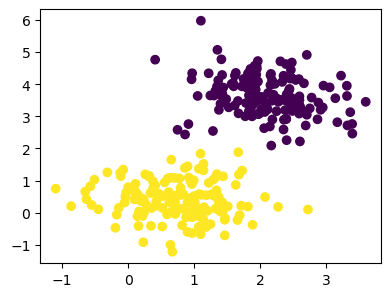

In [4]:
X, y = read_data("data/blobs300.csv")

### Train the Classifier

In [5]:
split = split_data(X, y, random_state=123456789)
X_train, X_valid, X_test, y_train, y_valid, y_test = split

clf = LogisticRegressionSGD(random_state=123456789)

clf.fit(X_train, y_train, X_valid, y_valid)
score = clf.score(X_test, y_test)

print(score)

1.0


### Plot the Learning Curve

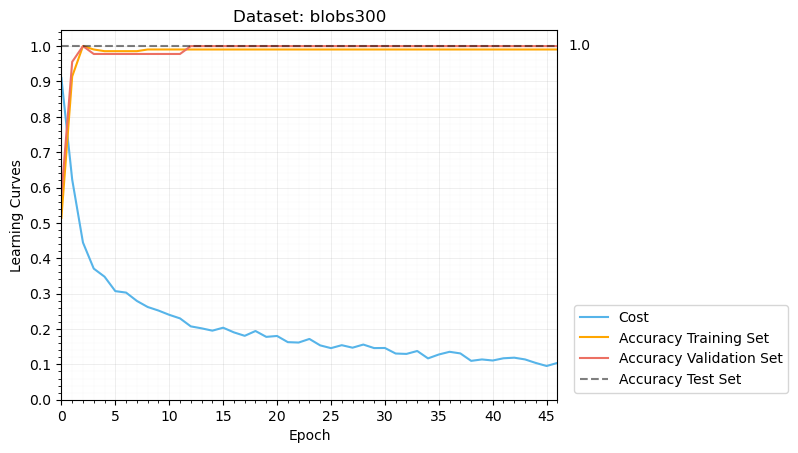

In [6]:
J, A_train, A_valid = zip(*clf.learning_curve_)

plot_learning_curves(J, A_train, A_valid, score, x_step=5,
                     title="Dataset: blobs300")

## Dataset: moons500

### Extract the Dataset

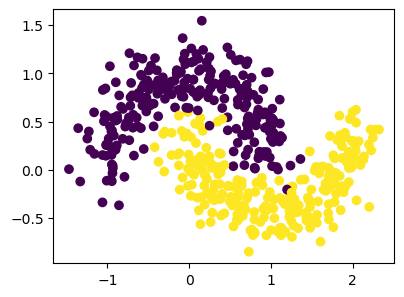

In [7]:
X, y = read_data("data/moons500.csv")

### Train the Classifier

In [8]:
split = split_data(X, y, random_state=12345678)
X_train, X_valid, X_test, y_train, y_valid, y_test = split

clf = LogisticRegressionSGD(random_state=1234567890, max_iterations=100000)

clf.fit(X_train, y_train, X_valid, y_valid)
score = clf.score(X_test, y_test)

print(score)

0.9066666666666666


### Plot the Learning Curve

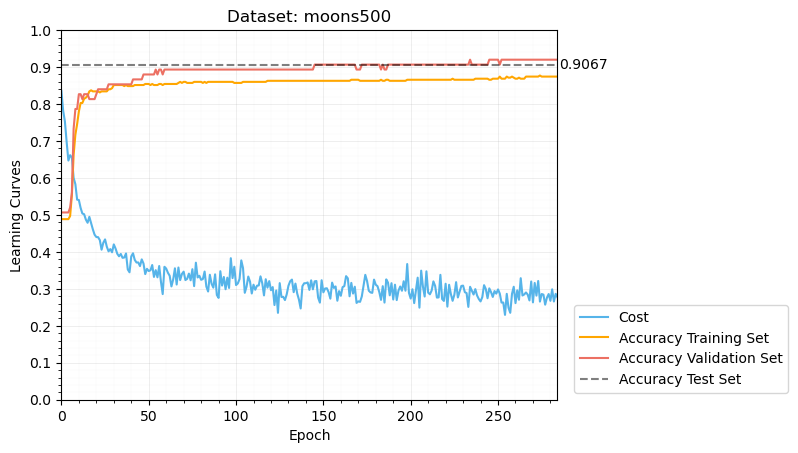

In [9]:
J, A_train, A_valid = zip(*clf.learning_curve_)

plot_learning_curves(J, A_train, A_valid, score, x_step=50,
                     title="Dataset: moons500")

# **Part 3: Implement a Shallow Neural Network**

## Brief description of algorithm

Going from a single neuron to a network with one hidden layer is fairly simple. Instead of connecting the inputs directly to the output node they are fully-connceted to an additional layer which is consisted of an arbitrary number of the same type of nodes (Logistic Regressors). This allows the representation of any continous function and enables handling more complex classification problems. Overall, the Shallow Neural Network follows the same general principals that have been implemented so far.

To transform the Logistic Regressor with SGD into a shallow neural network I have added a hidden layer between the input layer and the output layer. The hidden layer contains a set of neurons that use activation functions (I have used Sigmoid) to transform the input data into new representations that will be useful for the output layer to make predictions.

Here are the changes I have made to my code to add the hidden layer:
1. Update the constructor to take an additional argument `n_hidden` which is the number of neurons in the hidden layer.
2. Modify the `init_weights()` method to initialize the weights and biases for the hidden layer as well.
3. Modify the `forward_propagation()` method to compute the output of the hidden layer before passing it through the output layer.
4. Modify the `backward_propagation()` method to compute the gradients for the hidden layer weights and biases as well as the output layer weights and biases.
5. Modify the `fit()` method to update the weights and biases for both layers during each iteration of training.
6. Modify the `predict()` method to compute the output of the hidden layer as well as the output layer.

I have struggled a little bit to find the correct shapes of the weights matrices during the forward and backward propagation steps. That is why I have a little help from the online tutorial by Caceres [1] to find out the correct arithmetic operators that need to be used.

## Implementation

Implementation of a feed-forward neural network with 1 hidden layer and a standard kernel such as sigmoid, including backprop, extending the previous implementation of logistic regression.

In [10]:
class ShallowNeuralNetworkSGD(LogisticRegressionSGD):
    '''
    Shallow Neural Network binary classifier with one hidden layer and 1 output
    node using Logistic Regression and Stochastic Gradient Descent with
    batch_size = 1 for weights and bias optimisation.

    Parameters
    ----------
    n_hidden : array-like of shape(n_layers - 2,), default=(2,)
        The ith element represents the number of neurons in the ith hidden
        layer.
    learning_rate : float, default=0.001
        Controls the step-size in updating the weights.
    max_iterations : int, default=10000
        Maximum number of iterations. The solver iterates until convergence
        (detirmined by `threshold`) or this number of iterations.
    threshold : float, default=0.000001
        When the loss is not improving by at least `threshold` convergence is
        considered to be reached and training stops.
    random_state : int, default=None
        This is passed for reproducibility purposes.
    '''
    def __init__(self, learning_rate=0.001, max_iterations=10000,
                 threshold=0.000001, random_state=None, n_hidden=2):
        super().__init__(learning_rate, max_iterations, threshold, random_state)
        self.n_hidden = n_hidden
        
    def init_weights(self, X):
        _, n_features = X.shape

        # Initialize weights and biases for the hidden layer
        self.w1_ = self.random_state.normal(0, 0.1, (n_features, self.n_hidden))
        self.b1_ = np.ones((1, self.n_hidden))

        # Initialize weights and biases for the output layer
        self.w2_ = self.random_state.normal(0, 0.1, (self.n_hidden, 1))
        self.b2_ = np.ones((1, 1))
    
    def forward_propagation(self, x):
        # Forward propagation for the hidden layer
        z1 = x @ self.w1_ + self.b1_
        a1 = Sigmoid(z1)

        # Forward propagation for the output layer
        z2 = a1 @ self.w2_ + self.b2_
        a2 = Sigmoid(z2)

        return z1, a1, z2, a2
    
    def backward_propagation(self, x, y, z1, a1, a2):        
        # Backward propagation for the output layer
        delta_z2 = a2 - y
        delta_w2 = a1.T @ delta_z2
        delta_b2 = np.sum(delta_z2, axis = 0, keepdims=True)

        # Backward propagation for the hidden layer
        delta_z1 = Sigmoid_deriv(z1) * (delta_z2 @ self.w2_.T)
        delta_w1 = x.T @ delta_z1
        delta_b1 = np.sum(delta_z1, axis=0, keepdims=True)

        return delta_w1, delta_b1, delta_w2, delta_b2
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        self.init_weights(X_train)

        for _ in range(self.max_iterations):
            # Pick random {x, y}
            # Because we use SGD x is a 1D array so the dot product calculation
            # later in the back propagation step will fail because it expects a
            # 2D matrix, therefore we need to reshape it.
            x, y = self.pick_random_sample(X_train, y_train)
            x = np.reshape(x, (1, x.shape[0]))

            # Forward propagation
            z1, a1, z2, y_hat = self.forward_propagation(x)

            # Calculate loss and check for convergence
            self.calculate_loss(y, y_hat)

            if self.is_convergence_reached(X_train, y_train, X_valid, y_valid):
                break

            # Backward propagation
            (delta_w1, delta_b1,
             delta_w2, delta_b2) = self.backward_propagation(x, y,
                                                             z1, a1, y_hat)

            # Update the weights values in a direction to reduce cost as given
            # by the derivatives, by an amount controlled by the learning rate
            self.w1_ -= self.learning_rate * delta_w1
            self.b1_ -= self.learning_rate * delta_b1
            self.w2_ -= self.learning_rate * delta_w2
            self.b2_ -= self.learning_rate * delta_b2

        return self
    
    def predict(self, X):
        ''' Simply feedforward the pre-trained model. '''
        z1, a1, z2, y_hat = self.forward_propagation(X)

        return np.where(y_hat >= 0.5, 1, 0).reshape(-1)

## Dataset: blobs300

### Extract the Dataset

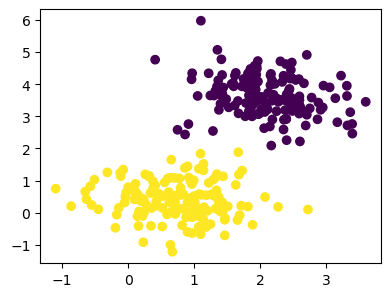

In [11]:
X, y = read_data("data/blobs300.csv")

### Train the Classifier

In [12]:
split = split_data(X, y, random_state = 123456789)
X_train, X_valid, X_test, y_train, y_valid, y_test = split

clf = ShallowNeuralNetworkSGD(random_state = 123456789, n_hidden = 10,
                              max_iterations = 100000)

clf.fit(X_train, y_train, X_valid, y_valid)
score = clf.score(X_test, y_test)

print(score)

1.0


### Plot the Learning Curve

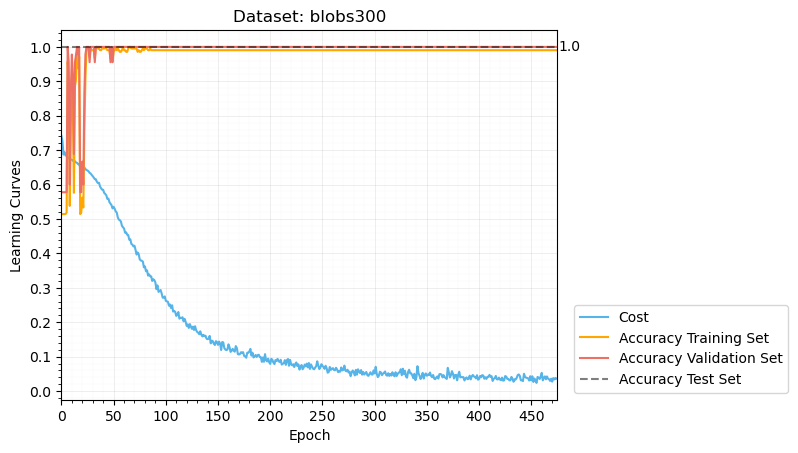

In [13]:
J, A_train, A_valid = zip(*clf.learning_curve_)

plot_learning_curves(J, A_train, A_valid, score, x_step = 50,
                     title="Dataset: blobs300")

## Dataset: moons500

### Extract the Dataset

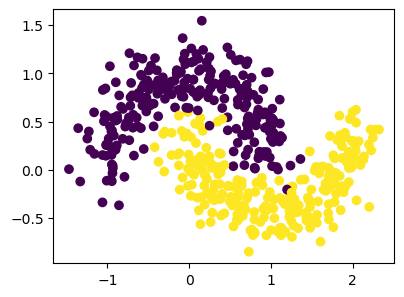

In [73]:
X, y = read_data("data/moons500.csv")

### Train the Classifier

In [75]:
split = split_data(X, y, random_state=12345678)
X_train, X_valid, X_test, y_train, y_valid, y_test = split

clf = ShallowNeuralNetworkSGD(random_state = 1234567890, n_hidden = 20,
                              max_iterations = 2000000)

clf.fit(X_train, y_train, X_valid, y_valid)
score = clf.score(X_test, y_test)

print(score)

0.9733333333333334


### Plot the Learning Curve

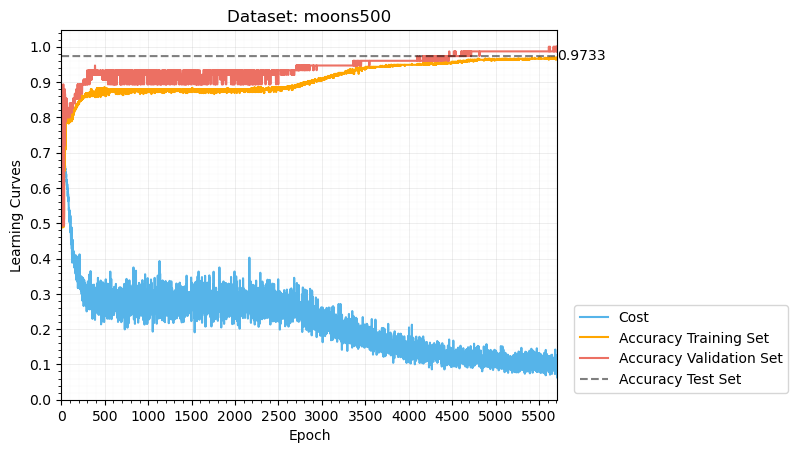

In [16]:
J, A_train, A_valid = zip(*clf.learning_curve_)

plot_learning_curves(J, A_train, A_valid, score, x_step = 500,
                     title="Dataset: moons500")

# **Part 4: Fashion-MNIST Dataset**

## Extract the Dataset

In [17]:
# This function taken directly from the Fashion-MNIST github site: 
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

# Note: first arg is the path name, second is the file prefix,
# either 'train'or 't10k' (which is 10k of test data)
def load_mnist(path, kind = 'train'): 
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype = np.uint8,
                               offset = 8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype = np.uint8,
                               offset = 16).reshape(len(labels), 784)

    return images, labels

# Loaded in this way, each of the batch files contains a dictionary with
# the following elements:
#   data -- a 10000x3072 numpy array of uint8s. Each row of the array stores
#           a 32x32 colour image. The first 1024 entries contain the red
#           channel values, the next 1024 the green, and the final 1024 the
#           blue. The image is stored in row-major order, so that the first
#           32 entries of the array are the red channel values of the first
#           row of the image.
#   labels -- a list of 10000 numbers in the range 0-9. 
#             The number at index i indicates the label of the ith image in
#             the array data.

In [18]:
def visualise(data, index):
    # MM Jan 2019: Given an MNIST data nparray and the index of an image,
    # display the image. Note that the images will be quite fuzzy looking,
    # because they are low res (28x28).

    picture = data[index]
    
    # Initially, the data is a 1D array of 784 pixels; reshape it to a 2D
    # array of 28x28 pixels
    pic = picture.reshape(28, 28)
    
    # Display it
    plt.imshow(pic, cmap = 'gray')
    plt.show()

In [19]:
label_names = ['T-shirt/top', 'Trouser' , 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [20]:
train_imgs, train_labels = load_mnist('./data', 'train')
test_imgs, test_labels = load_mnist('./data', 't10k')

## Preprocess the Data

My provided pair of classes is: **Dress, Bag**.

In [21]:
pair_classes = {'Dress': 3, 'Bag': 8}

In [22]:
def filter_samples(X, y):
    X_filtered, y_filtered = zip(*[(x, y)
                                   for x, y in zip(X, y)
                                   if y in pair_classes.values()])
    
    return (np.array(X_filtered, dtype=float),
            np.array(y_filtered, dtype=float))

def encode_labels(y):
    ''' Map labels to 0 and 1 values ('Dress' is 1, 'Bag' is 0). '''
    return np.where(y == pair_classes['Dress'], 1, 0)

def decode_labels(y):
    ''' Map labels to pair class values (1 is 'Dress', 0 is 'Bag'). '''
    return np.where(y == 1, pair_classes['Dress'], pair_classes['Bag'])

def img_scale(X):
    ''' Scale down data from 0-255 to 0-1. '''
    return X / 255

def preprocess_MNIST(train_imgs, test_imgs, train_labels, test_labels):
    # Filter only "Dress" and "Bag" samples
    X_temp, y_temp = filter_samples(train_imgs, train_labels)
    X_test, y_test = filter_samples(test_imgs, test_labels)

    # Extract a validation set from the training images that is euqal in size
    # to the testing dataset
    valid_size = len(X_test) / len(X_temp)
    (X_valid, X_train,
     y_valid, y_train) = train_test_split(X_temp, y_temp,
                                          train_size = valid_size,
                                          random_state = 12345678)

    # Encode labels to be in a suitable format for the shallow neural network
    y_train = encode_labels(y_train)
    y_valid = encode_labels(y_valid)
    y_test = encode_labels(y_test)

    # Normalize the data in a 0-1 range
    X_train = img_scale(X_train)
    X_valid = img_scale(X_valid)
    X_test = img_scale(X_test)

    # Display a few images that we loaded
    for i in range (5, 7):
        id = decode_labels(y_train[i])
        visualise(X_train, i)
        print("Image", i,": Class is ", label_names[id],
              "class id=", id)

    return (X_train, X_valid, X_test,
            y_train, y_valid, y_test,)

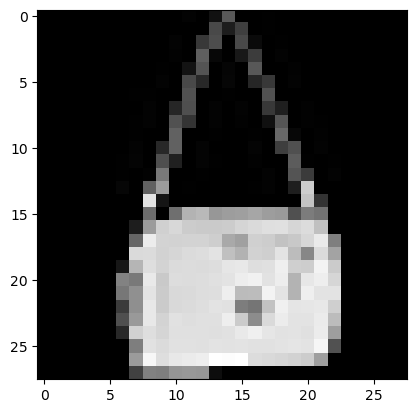

Image 5 : Class is  Bag class id= 8


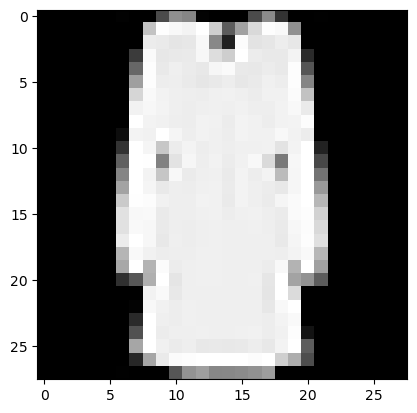

Image 6 : Class is  Dress class id= 3


In [23]:
(X_train, X_valid, X_test,
 y_train, y_valid, y_test) = preprocess_MNIST(train_imgs, test_imgs,
                                              train_labels, test_labels)

In [24]:
datasets = ["train", "validation", "test"]
shapes = np.array([X_train.shape, X_valid.shape, X_test.shape])[:, 0]
ratios = (shapes / np.sum(shapes)) * 100
f = lambda x: f'{round(x, 2)}%'

df_mnist_summary = pd.DataFrame({"Dataset split": datasets,
                                 "Num samples": shapes,
                                 "Part of total": map(f, ratios)})
df_mnist_summary

,Dataset split,Num samples,Part of total
0,train,10000,71.43%
1,validation,2000,14.29%
2,test,2000,14.29%


## Parameter Tuning

In order to detirmine the optimal number of nodes in the hidden layer for the Fashion-MNIST dataset I have trained the shallow network for **1**, **20** and **100** epochs with different `n_hidden` values. I have decided to use numbers from the geometric progression of powers of 2: **{2, 4, 8, 16, 32, 64, 128, 256, 512, 1024}**. I also decided to include **{1}** so I could make a hard estimate how long the larger number of epochs is going to take. I also decided to include **{392, 784, 1568}** which are half of `n_samples`, `n_samples`, and 2 x `n_samples`. I have stored the results in a csv file and I have plotted the results in the next cell.

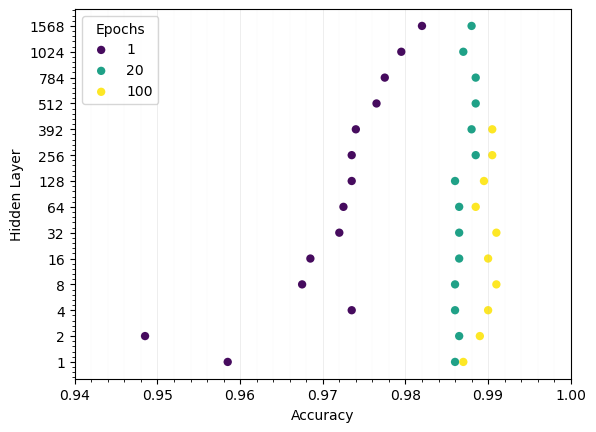

In [25]:
df = pd.read_csv('data/task4_tuning.csv')

accuracy = df['accuracy'].tolist()
n_hidden = df['n_hidden'].tolist()
n_hidden = list(map(str, n_hidden))
n_epoch = df['n_epoch'].tolist()
time = df['time'].tolist()

df2 = pd.DataFrame({"accuracy": np.array(accuracy).flatten(),
                   "n_hidden": np.array(n_hidden).flatten(),
                   "n_epoch": np.array(n_epoch).flatten(),
                   "time": np.array(time).flatten()})

cmap = plt.cm.viridis
norm = plt.Normalize(0, 35)

plt.figure(2)

for i, dff in df2.groupby("n_epoch"):
    plt.scatter(dff['accuracy'], dff['n_hidden'], c = cmap(norm(dff['n_epoch'])), 
                edgecolors = 'none', label = "Feature {:g}".format(i))

plt.grid(visible = True, which = 'major', alpha = 0.3, linewidth = 0.5)
plt.grid(visible = True, which = 'minor', alpha = 0.25, linewidth = 0.1)
plt.minorticks_on()
plt.gca().yaxis.grid(False, which = "both")
plt.xticks(np.arange(0.94, 1.0, 0.01))
plt.xlabel('Accuracy')
plt.ylabel('Hidden Layer')
plt.legend(['1', '20', '100'], title = "Epochs", loc = 'upper left')
plt.show()

I have decided not to train networks for 100 epochs for `n_hidden` > 392 because it takes a lot of time and from the pattern I see in the dot plot my intuition tells me that there isn't going to be any further improvement in the accuracy.

In [26]:
df2.sort_values(by=['accuracy', 'n_hidden'], ascending=False)[:5]

,accuracy,n_hidden,n_epoch,time
11,0.9910,8,100,4m 11.9s
17,0.9910,32,100,5m 52.8s
29,0.9905,392,100,59m 18s
26,0.9905,256,100,40m 23.1s
8,0.9900,4,100,3m 45.2s


We can see that the best accuracies are given by `n_hidden` = 8 and `n_hidden` = 32. Because `n_hidden` = 8 takes less time to train I have chosen to use it as a value for `n_hidden`.

## Train the Shallow Neural Network

In [27]:
epoch = X_train.shape[0] # 10000
clf = ShallowNeuralNetworkSGD(random_state=1234567890, n_hidden = 8,
                              max_iterations = epoch*100)

clf.fit(X_train, y_train, X_valid, y_valid)
score = clf.score(X_test, y_test)

print(score)

0.991


## Plot the Learning Curve

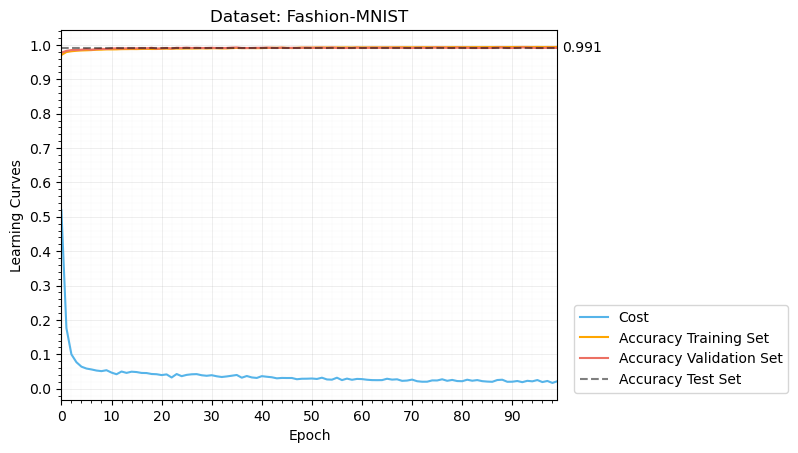

In [28]:
J, A_train, A_valid = zip(*clf.learning_curve_)

plot_learning_curves(J, A_train, A_valid, score, x_step=10,
                     title = "Dataset: Fashion-MNIST")

# **Part 5: Deep Learning Enhancements**

## Brief description of your enhancement to the algorithm

This part consists of 2 steps.

Step 1 involves changing the shallow network code to support an arbitrary number of layers, and an arbitrary different number of nodes in each layer, hence upgrade it to a deep network model.

Step 2 involves picking one other enhancement that is characteristic of deep learning.

As part of this step I have decided to implement **Early Stopping**. Early stopping is one of the most commonly used methods which aims to avoid overfitting of the deep neural network model [2]. There exists a tradeoff between training time and generalisation. Especially when it comes to more complex models in relation to the size of the training data, the more training time (epochs) the higher the probability of overfitting becomes. Various regularization techniques like early stopping have been developed to try to address this issue. There is a corelation between the learning curves of the training and the validation sets. A big warning sign of overfitting is when the performance of then network with respet to the validation set starts disimproving. The basic early stopping method involves monitoring the learning curve and stopping the training process as soon as the validation curve starts disimproving (reverses).

However, in reality the learning curves are not nearly as smooth as the ones shown in the figure [2]. There might be some temporary decreases of performance on the valdiation set but over time the model might still improve even further. There are some more complex regularisaton methods that don't halt the model immediatly when they see disimprovement, but I have decided to implement a simpler form of the early stopping.

My implementation doesn't involving actually "stopping" the training but instead records the best performance on the validation set so far at every couple of iterations (I have set 100 as default as mentioned in the lecture slides of this module). After training is done, I just return the best weights instead of the ones that are computed at the final iteration.

Finally, after performing parameter tuning to find out an optimal number of layers and nodes in each of them, I test how well these enhancements work relative to the shallow NN on the image dataset.

## Implementation

Implementation of a deep neural network that supports an arbitrary number of layers, and an arbitrary different number of nodes in each layer.

In [63]:
def ReLU(x):
    return np.maximum(0, x)

def ReLU_deriv(x):
    return (x > 0) * 1

def print_network_structure(w_hidden, b_hidden, w_output, b_output):
    for i in range(len(w_hidden)):
        print(f'Layer {i}:')
        print(f'weigths: {w_hidden[i].shape}')
        print(f'biases:  {b_hidden[i].shape}\n')

    print(f'Output Layer:')
    print(f'weigths: {w_output.shape}')
    print(f'biases: {b_output.shape}\n')

class DeepNeuralNetworkSGD(LogisticRegressionSGD):
    '''
    Deep Neural Network binary classifier with arbitrary number of hidden
    layers, an arbitrary different number of nodes in each layer, and 1
    output node, using Logistic Regression and Stochastic Gradient Descent
    with batch_size = 1 for weights and bias optimisation.

    Parameters
    ----------
    n_hidden : array-like of shape(n_layers - 2,), default=(2,)
        The ith element represents the number of neurons in the ith hidden
        layer.
    learning_rate : float, default=0.001
        Controls the step-size in updating the weights.
    max_iterations : int, default=10000
        Maximum number of iterations. The solver iterates until convergence
        (detirmined by `threshold`) or this number of iterations.
    threshold : float, default=0.000001
        When the loss is not improving by at least `threshold` convergence is
        considered to be reached and training stops.
    random_state : int, default=None
        This is passed for reproducibility purposes.
    early_stopping_interval : int, default=100
        Early stopping tries to avoid overfitting by saving the best model
        parameters at every `early_stopping_interval` iterations. After
        training is finished the best parameters are returned instead of
        the final ones.
    '''
    def __init__(self, learning_rate = 0.001, max_iterations = 10000,
                 threshold = 0.000001, random_state = None, n_hidden = (2,),
                 early_stopping=False, early_stopping_interval = 100):
        super().__init__(learning_rate, max_iterations,
                         threshold, random_state)
        self.n_hidden = n_hidden
        self.early_stopping = early_stopping
        self.early_stopping_interval = early_stopping_interval
        
    def init_weights(self, X):
        _, n_features = X.shape
        self.w_hidden_ = np.empty(shape = len(self.n_hidden), dtype = object)
        self.b_hidden_ = np.empty(shape = len(self.n_hidden), dtype = object)

        # Initialize weights and biases for the hidden layers
        for l, n in enumerate(self.n_hidden):
            n_input = self.n_hidden[l - 1] if l > 0 else n_features
            self.w_hidden_[l] = self.random_state.normal(0, 0.1, (n_input, n))
            self.b_hidden_[l] = np.ones((1, n))

        # Initialize weights and biases for the output layer
        self.w_output_ = self.random_state.normal(0, 0.1,
                                                  (self.n_hidden[-1], 1))
        self.b_output_ = np.ones((1, 1))

        print_network_structure(self.w_hidden_, self.b_hidden_,
                                self.w_output_, self.b_output_)
    
    def forward_propagation(self, x):
        z_hidden = np.empty(shape = len(self.n_hidden), dtype = object)
        a_hidden = np.empty(shape = len(self.n_hidden), dtype = object)

        # Forward propagation for the hidden layers
        for l in range(len(self.n_hidden)):
            a_previous = a_hidden[l - 1] if l > 0 else x
            z_hidden[l] = a_previous @ self.w_hidden_[l] + self.b_hidden_[l]
            a_hidden[l] = ReLU(z_hidden[l])

        # Forward propagation for the output layer
        z_output = a_hidden[-1] @ self.w_output_ + self.b_output_
        a_output = Sigmoid(z_output)

        return z_hidden, a_hidden, z_output, a_output
    
    def backward_propagation(self, x, y, z_hidden, a_hidden, a_output):
        # Backward propagation for the output layer
        delta_z_output = a_output - y
        delta_w_output = a_hidden[-1].T @ delta_z_output
        delta_b_output = np.sum(delta_z_output, axis = 0, keepdims=True)

        delta_z_hidden = np.empty(shape = len(self.n_hidden), dtype = object)
        delta_w_hidden = np.empty(shape = len(self.n_hidden), dtype = object)
        delta_b_hidden = np.empty(shape = len(self.n_hidden), dtype = object)

        # Backward propagation for the hidden layer
        for l in reversed(range(len(self.n_hidden))):
            delta_z_next = (delta_z_hidden[l + 1] if l < len(self.n_hidden) - 1
                            else delta_z_output)
            w_next = (self.w_hidden_[l + 1] if l < len(self.n_hidden) - 1
                      else self.w_output_)
            a_previous = a_hidden[l - 1] if l > 0 else x

            delta_z = ReLU_deriv(z_hidden[l]) * (delta_z_next @ w_next.T)
            delta_w_hidden[l] = a_previous.T @ delta_z
            delta_b_hidden[l] = np.sum(delta_z, axis=0, keepdims=True)

            delta_z_hidden[l] = delta_z

        return delta_w_output, delta_b_output, delta_w_hidden, delta_b_hidden
    
    def perform_early_stopping(self, X_valid, y_valid):
        '''
        At every `n` intervals where `n` = `early_stopping_interval` the current
        network is tested on the validation set. If the performance at the
        current time is better than the best previous performace, the model
        parameters are saved.
        '''
        n_iterations = len(self.loss_curve_)

        if n_iterations % self.early_stopping_interval == 0:
            A_valid = self.score(X_valid, y_valid)

            if A_valid > self.max_accuracy_:
                self.max_accuracy_ = A_valid
                self.best_params_ = (self.w_hidden_, self.b_hidden_,
                                     self.w_output_, self.b_output_)
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        self.init_weights(X_train)

        # Initialize variables required by the early stopping method
        if self.early_stopping:
            self.max_accuracy_ = self.score(X_valid, y_valid)
            self.best_params_ = (self.w_hidden_, self.b_hidden_,
                                 self.w_output_, self.b_output_)

        for _ in range(self.max_iterations):
            # Pick random {x, y}
            # Because we use SGD x is a 1D array so the dot product calculation
            # later in the back propagation step will fail because it expects a
            # 2D matrix, therefore we need to reshape it.
            x, y = self.pick_random_sample(X_train, y_train)
            x = np.reshape(x, (1, x.shape[0]))

            # Forward propagation
            z_hidden, a_hidden, z_output, y_hat = self.forward_propagation(x)

            # Calculate loss and check for convergence
            self.calculate_loss(y, y_hat)

            if self.is_convergence_reached(X_train, y_train, X_valid, y_valid):
                break

            # Early Stopping
            if self.early_stopping:
                self.perform_early_stopping(X_valid, y_valid)

            # Backward propagation
            (delta_w_output,
             delta_b_output,
             delta_w_hidden,
             delta_b_hidden) = self.backward_propagation(x, y, z_hidden,
                                                         a_hidden, y_hat)

            # Update the weights values in a direction to reduce cost as given
            # by the derivatives, by an amount controlled by the learning rate
            self.w_hidden_ -= self.learning_rate * delta_w_hidden
            self.b_hidden_ -= self.learning_rate * delta_b_hidden
            self.w_output_ -= self.learning_rate * delta_w_output
            self.b_output_ -= self.learning_rate * delta_b_output

        # When finished training, use the best saved parameters instead of
        # the final parameters
        if self.early_stopping:
            self.w_hidden_ = self.best_params_[0]
            self.b_hidden_ = self.best_params_[1]
            self.w_output_ = self.best_params_[2]
            self.b_output_ = self.best_params_[3]
        
        return self
    
    def predict(self, X):
        ''' Simply feedforward the pre-trained model. '''
        z_hidden, a_hidden, z_output, y_hat = self.forward_propagation(X)

        return np.where(y_hat >= 0.5, 1, 0).reshape(-1)

## Parameter Tuning

In order to detirmine the optimal number of nodes and hidden layers I have decided to experiment with a few different configurations for **1** and **20** epochs. I have decided to follow a pyramidal structure of the layer - each subsequent layer having less number of neurons than the previous layer (I have decided to make each subsequent layer half the size of its preceeding layer). As a first layer I have considered the top 5 results from the shallow network approach which are **{2, 4, 8, 16, 32, 64, 128, 256, 512, 1024}**. Then, I have included configuration of 2, 3 and 4 hidden layers. I have stored the results in a csv file and I have plotted the results in the next cell.

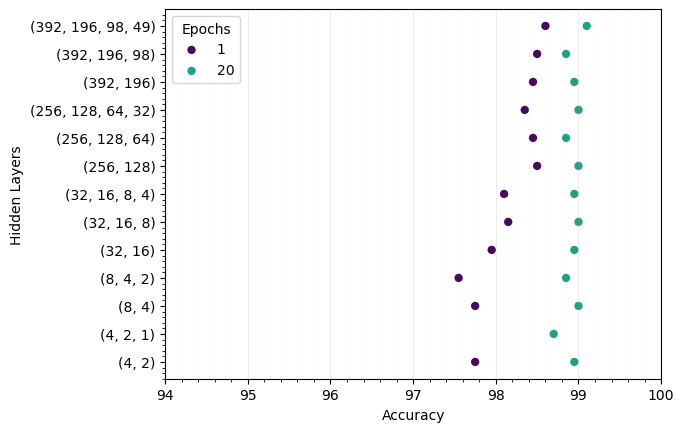

In [65]:
df = pd.read_csv('data/task5.1_tuning.csv')

accuracy = df['accuracy'].tolist()
n_hidden = df['n_hidden'].tolist()
n_hidden = list(map(str, n_hidden))
n_epoch = df['n_epoch'].tolist()
time = df['time (m)'].tolist()

df3 = pd.DataFrame({"accuracy": np.array(accuracy).flatten(),
                   "n_hidden": np.array(n_hidden).flatten(),
                   "n_epoch": np.array(n_epoch).flatten(),
                   "time (m)": np.array(time).flatten()})

cmap = plt.cm.viridis
norm = plt.Normalize(0, 35)

plt.figure(2)

for i, dff in df3.groupby("n_epoch"):
    plt.scatter(dff['accuracy'], dff['n_hidden'], c = cmap(norm(dff['n_epoch'])), 
                edgecolors = 'none', label = "Feature {:g}".format(i))

plt.grid(visible = True, which = 'major', alpha = 0.3, linewidth = 0.5)
plt.grid(visible = True, which = 'minor', alpha = 0.25, linewidth = 0.1)
plt.minorticks_on()
plt.gca().yaxis.grid(False, which = "both")
plt.xticks(np.arange(94, 100.1, 1))
plt.xlim(left=94)
plt.xlabel('Accuracy')
plt.ylabel('Hidden Layers')
plt.legend(['1', '20', '100'], title = "Epochs", loc = 'upper left')
plt.show()

In [62]:
df3.sort_values(by=['accuracy', 'n_hidden'], ascending=False)[:5]

,accuracy,n_hidden,n_epoch,time (m)
25,99.1,"(392, 196, 98, 49)",20,20.88
15,99.0,"(8, 4)",20,0.98
18,99.0,"(32, 16, 8)",20,1.62
22,99.0,"(256, 128, 64, 32)",20,11.35
20,99.0,"(256, 128)",20,11.01


We can see that the best accuracies are given by `n_hidden = (392, 196, 98, 49)`. Unfortunately, due to the time it took to train 20 epochs which was 20.88 minutes, I didn't have neought time to explore this configuration for a larager number of epochs (in the midst of the hundreds) because it would have taken hours ot train. That is why I have decided to opt out for the second best option, which is `n_hidden = (8, 4)`. In the following cell I have trained the network with the selected configuration for 500 epochs.

## Train the Shallow Neural Network

In [70]:
epoch = X_train.shape[0] # 10000
clf = DeepNeuralNetworkSGD(random_state = 1234567890,
                           n_hidden = (8, 4),
                           max_iterations = epoch * 500,
                           early_stopping = True,
                           early_stopping_interval = 100)

clf.fit(X_train, y_train, X_valid, y_valid)
score = clf.score(X_test, y_test)

print(score)

Layer 0:
weigths: (784, 8)
biases:  (1, 8)

Layer 1:
weigths: (8, 4)
biases:  (1, 4)

Output Layer:
weigths: (4, 1)
biases: (1, 1)

0.988


## Plot the Learning Curve

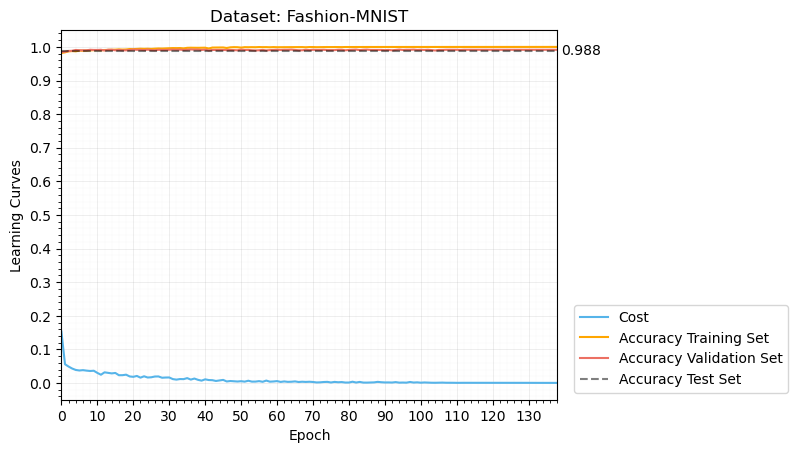

In [72]:
J, A_train, A_valid = zip(*clf.learning_curve_)

plot_learning_curves(J, A_train, A_valid, score, x_step = 10,
                     title="Dataset: Fashion-MNIST")

# Summary of Results

| Dataset       | Model                   | Parameters | Accuracy |
| ------------- | ----------------------- | ---------- | -------- |
| Blobs         | LogisticRegressionSGD   | default    | 100.0    |
| Blobs         | ShallowNeuralNetworkSGD | max_iterations=100000, n_hidden=10 | 100.0    |
| Moons         | LogisticRegressionSGD   | max_iterations=100000 | 90.67    |
| Moons         | ShallowNeuralNetworkSGD | max_iterations=2000000, n_hidden=20 | 97.33    |
| Fashion-MNIST | ShallowNeuralNetworkSGD | n_hidden=8, max_iterations=epoch*100 | 99.10     |
| Fashion-MNIST | DeepNeuralNetworkSGD    | n_hidden=(8,4), max_iterations=epoch*500, early_stopping=True, early_stopping_interval=100 | 98.80     |

From the results of the different models on the different datasets I have made the following observations.

1. The Blobs dataset is very easy because it is linearly separable. That is why it was very easy to achieve 100% accuracy regardless the model. I would expect to get the same performance even with classical transparent Machine Learning techniques.

2. The Moons dataset appeared to be a bit more difficult. Because it isn't linearly separable it is impossible to achieve good results with the first model. We can see a considerable improvement of nearly 7% by using the Shallow Neural Network. I suppose with better param tuning even higher results might be possible but I didn't want to spend unnecessary time on the problem.

3. The Fashion-MNIST dataset is indeed much more complex, but due to the large number of available samples and the even distribution of classes the Shallow Neural Network was able to achieve very high accuracy of 99.1%. However, by looking at the learning curve could see how the performace on the validation set plateaued really fast in first coule of epochs. There is no guarantee how well is the model generalized, so that may lead to potentially worse performance in the real-world. On the other hand, DeepNeuralNetworkSGD with Early Stopping achieved a little lower accurracy by just 0.3 difference. Nevertheless, it could still potentially outperform the former approach in a real-world scenario because it is supposed to be better generalized.

# References:

[1] P. Caceres. "The Multilayer Perceptron - Theory and Implementation of the Backpropagation Algorithm". GitHub Pages. https://pabloinsente.github.io/the-multilayer-perceptron (access Feb. 16, 2023).

[2] L. Prechelt. "Early stopping—but when?" in "Neural Networks: Tricks of the Trade, 2nd ed, 2012. pp. 53-67. https://www.doi.org/10.1007/978-3-642-35289-8

[3] "Multi-Layer Neural Network". UFDL Tutorial. http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/ (access Feb. 18, 2023).

[4] I. Goodfellow and Y. Bengio, and A. Courville. "Deep learning". MIT press, 2016.